# Introduction: Anova model estimators

Given some train data $(x_i, y_i)$ for $i \in \{1, \ldots, N\}$, we are interested in finding the mapping function $f$ such that:
$$y_i=f_i(x_i)+\varepsilon_i$$
where  $\varepsilon_i$ is a noise. More particularly, we consider the multidimensional i.e. $x_i \in [0,1]^D$, and we assume that the mapping function reads:
$$f(x)=c+\sum_{i=1}^D f_i(x_i)+\sum_{k=1}^{D-1} \sum_{j=k+1}^D f_{k,j}(x_i, x_j) + \ldots$$
where $c$ is a constant, $f_i$ refers the a main component and $f_{k,j}$ refers to a first interaction componenent etc.
Such a decomposition is known as the ANOVA decomposition. 

To ensure the unicity of the decomposition, we assume that each main component belongs to the RKHS with the Sobolev kernel given by:
$$𝑘(s,t)=\dfrac{𝐵_{2𝑟} (|s-t |}{(−1)^{𝑟+1} (2𝑟)!}+\sum_{𝑖=1}^𝑟\dfrac{𝐵_𝑖 (s) 𝐵_𝑖(t)}{(𝑖!)^2} $$ 
where $𝐵_𝑖$ is the Bernoulli polynomial of degree $𝑖$.

For the first interaction effect, we have then used the following kernel :
$$\tilde{k}([s_1, t_1], [s_2, t_2])=𝑘(s_1,t_1)𝑘(s_2,t_2)$$


Note that, slight modifications are proposed in the litterature such as in [Brian, 2008].

The problem amounts then to estimate each of the component in the decomposition. 
In this notebook, we present 3 methods to do this estimation namely :
- Smoothing Spline Anova Model (SS module)
- (Adapative) COmponent Selection and Smoothing Operator (COSSO module)
- Local Global Bayesian COmponent Selection with SAMpling (LGBayesCOS module)



But, first defines the train data, the test data and the Sobolev model.  



# Imports 

In [32]:
import math
import warnings

import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.optim import SGD, RMSprop

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%matplotlib inline
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from bayesanova.models.utils import first_order_InteractionEffect_to_index
from bayesanova.examples import simulated_data
from bayesanova.anova_estimators import ss, cosso, lgbayescos
from bayesanova.models import model, prior
from bayesanova.samplers.utils import draw_parameters_densities, variance_estimation_from_samples
from bayesanova.samplers.stein import SteinRBFkernel, SteinIMQkernel

# Set the model preferences for Sobolev kernel

In [34]:
poly_order = 1 # Polynomial order
model_order = 2 # Model order 
residual = False # If true include residual component  (Only available for Bayesian)
coef = None # A constant to weight Bernoulli Polynomials. If None, use factorials 
correction = False # Correct the interaction effects if True as in [Brian, 2008]

*Remark*:
- In the current version, SS and (A)cosso models are only defined for main effects and first order interaction effects. 
- Then, for now, the variables 'residual', 'weight' and 'correction' are only taken into account in Bayesian selection methods.

# Train data and test data from examples

In [35]:
# for reproducibility
np.random.seed(seed=18)
torch.manual_seed(18)

if model_order == 1:
    D = 10
    N = 100
    train_x, train_y, train_f, train_f0, train_f1, train_f2, train_f3 = \
        simulated_data.example1(N=N, d=D, noise=2.28 ** 2, data='unif')
elif model_order == 2:
    D = 10
    N = 250
    train_x, train_y, train_f, train_f0, train_f1, train_f2, train_f3, train_f01, train_f02, train_f23 = \
        simulated_data.example2(N=N, d=D, noise=0.66 ** 2, data='unif')

In [36]:
# test data is equally spaced points 
test_x = torch.linspace(0, 1, 50).view(-1, 1).repeat(1, D)
if model_order == 1:
    test_f0, test_f1, test_f2, test_f3 = simulated_data.examplef1(test_x)  # True values
    test_f = test_f0 + test_f1 + test_f2 + test_f3
elif model_order == 2:
    test_f0, test_f1, test_f2, test_f3, test_f01, test_f02, test_f23 = simulated_data.examplef2(test_x)  # True values
    test_f = test_f0 + test_f1 + test_f2 + test_f3 + test_f01  + test_f02 + test_f23


# SS-Anova

## Define the SS-Anova estimator

When the noise is Gaussian, the Smoothing Spline (SS module) gives this estimation. The problem solved by SS model reads:
$$f \in argmin \sum_{i=1}^N (y_i−f(x_i ))^2+\alpha^{−1} \sum_{𝑗=1}^𝐽 𝑤_𝑗^{-1} \Vert 𝑃^𝑗 𝑓\Vert^2$$
where $𝑃^𝑗$ is the projection of $f$ in the RKHS of functional component $f_j$ (being either main effect, interaction effect, constant etc). There are two tuning parameters : 
- the regularization parameter $\alpha$ tuned with cross validation 
- a weighting parameter $𝑤_𝑗$ set from an initial estimator : bigger $𝑤_𝑗$ means promotes zero $f_j$

The default SS model is defined without weighting. But, we can add weighting parameters by setting the weight input.






In [6]:
# Optionally, we define the weight of size equal to the numbers of function components. Default weights is 1. 

# It is possible to choose custom weights
# Ensure that the sum~num_components (so that to keep the same alpha range)

# This is an example of weight (not optimal), decomment this part to test
weight_main_effect = torch.tensor([0.001, 0.001, 0.001, 0.001, 1.66,  1.66, 1.66, 1.66, 1.66, 1.66])
weight_interaction_effect = None 

# Weight can be either None or a tuple of size model_order
if model_order == 1: 
    weight_ss=(weight_main_effect,)
elif model_order == 2:
    weight_ss=(weight_main_effect, weight_interaction_effect)

# Default weight is None 
weight_ss = None # Please comment this line to use the custom weights example


# Finally, create the ss estimator
ss_estimator = ss.SS(ndims=D, weight=weight_ss, model_order=model_order, poly_order=poly_order)

## Training

- Train the SS model for a given regularization parameter $\alpha$

In [7]:
alpha_star = 0.1
_ = ss_estimator.train(train_x, train_y, GCV=False, alpha=alpha_star)

-  Or get the optimal value of the smoothing parameter from a grid with k-folds while training the data

In [13]:
L = 10
tab_alpha = 10. ** torch.arange(-6, -1, 1/L) / N
alpha_star, loss_star = ss_estimator.train(train_x, train_y, GCV=False, alpha=tab_alpha, 
                                                            folds=4, random_state=123456)

In [14]:
print('Optimal value for alpha is %0.6f' %(alpha_star.item()))

Optimal value for alpha is 0.000100


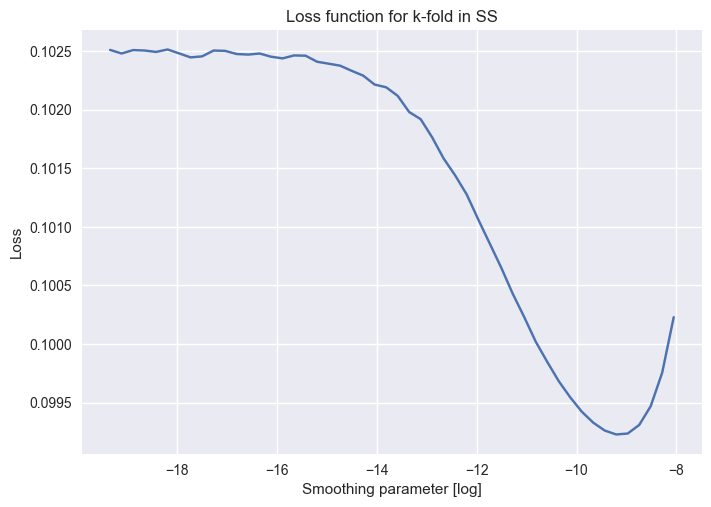

In [15]:
plt.plot(torch.log(tab_alpha), loss_star.detach()); 
plt.title('Loss function for k-fold in SS')
plt.xlabel('Smoothing parameter [log]')
plt.ylabel('Loss')
plt.show()

## Prediction 

- Apply trained model

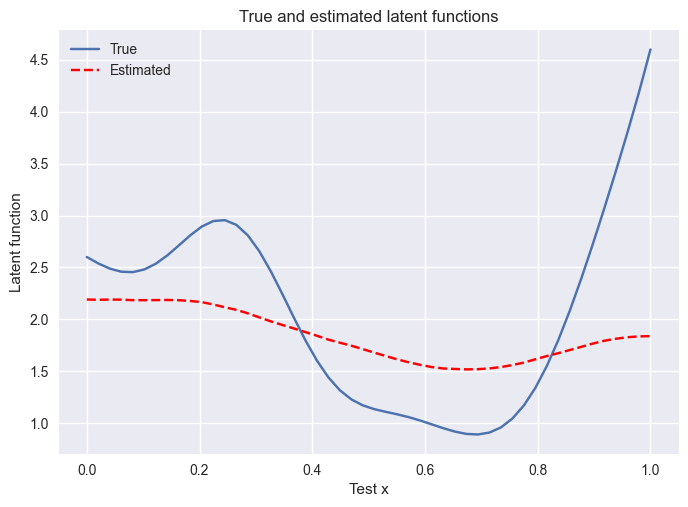

In [8]:
# Get the estimated latent
y_test_pred = ss_estimator.predict(test_x)

plt.plot(test_x[:, 0], test_f, label='True')
plt.plot(test_x[:, 0], y_test_pred.detach(), '--r', label='Estimated')
plt.legend()
plt.xlabel('Test x')
plt.ylabel('Latent function');
plt.title('True and estimated latent functions');

In [9]:
# Get the estimated functional components

# Two methods : 

# First method : return a tuple (main_comp, inter_comp) where main_comp and inter_comp are tensors
comp_test_ss = ss_estimator.get_components(test_x)

if model_order == 1:
    comp_test_main_effect_ss = comp_test_ss
    # No interaction effect
elif model_order == 2:
    comp_test_main_effect_ss = comp_test_ss[0]
    comp_test_interaction_effect_ss = comp_test_ss[1]
    
# Second method : call predict and specifying kind argument => return a dictionary {index : component}
target_component = None # If target component is the 4 then set 4, for two 4 and 5 target components then set [4, 5]
comp_test_main_effect_ss = ss_estimator.predict(test_x, kind='main', component_index=target_component)
if model_order == 2:
    target_component = None # If target component is the (0,1) then set [0, 1] if (0,1) and (4,5) then set [[0, 1], [4, 5]]
    comp_test_interaction_effect_ss = ss_estimator.predict(test_x, kind='interaction', component_index=target_component)



Function component 4 does not exist in the model
Function component 5 does not exist in the model
Function component 6 does not exist in the model
Function component 7 does not exist in the model
Function component 8 does not exist in the model
Function component 9 does not exist in the model


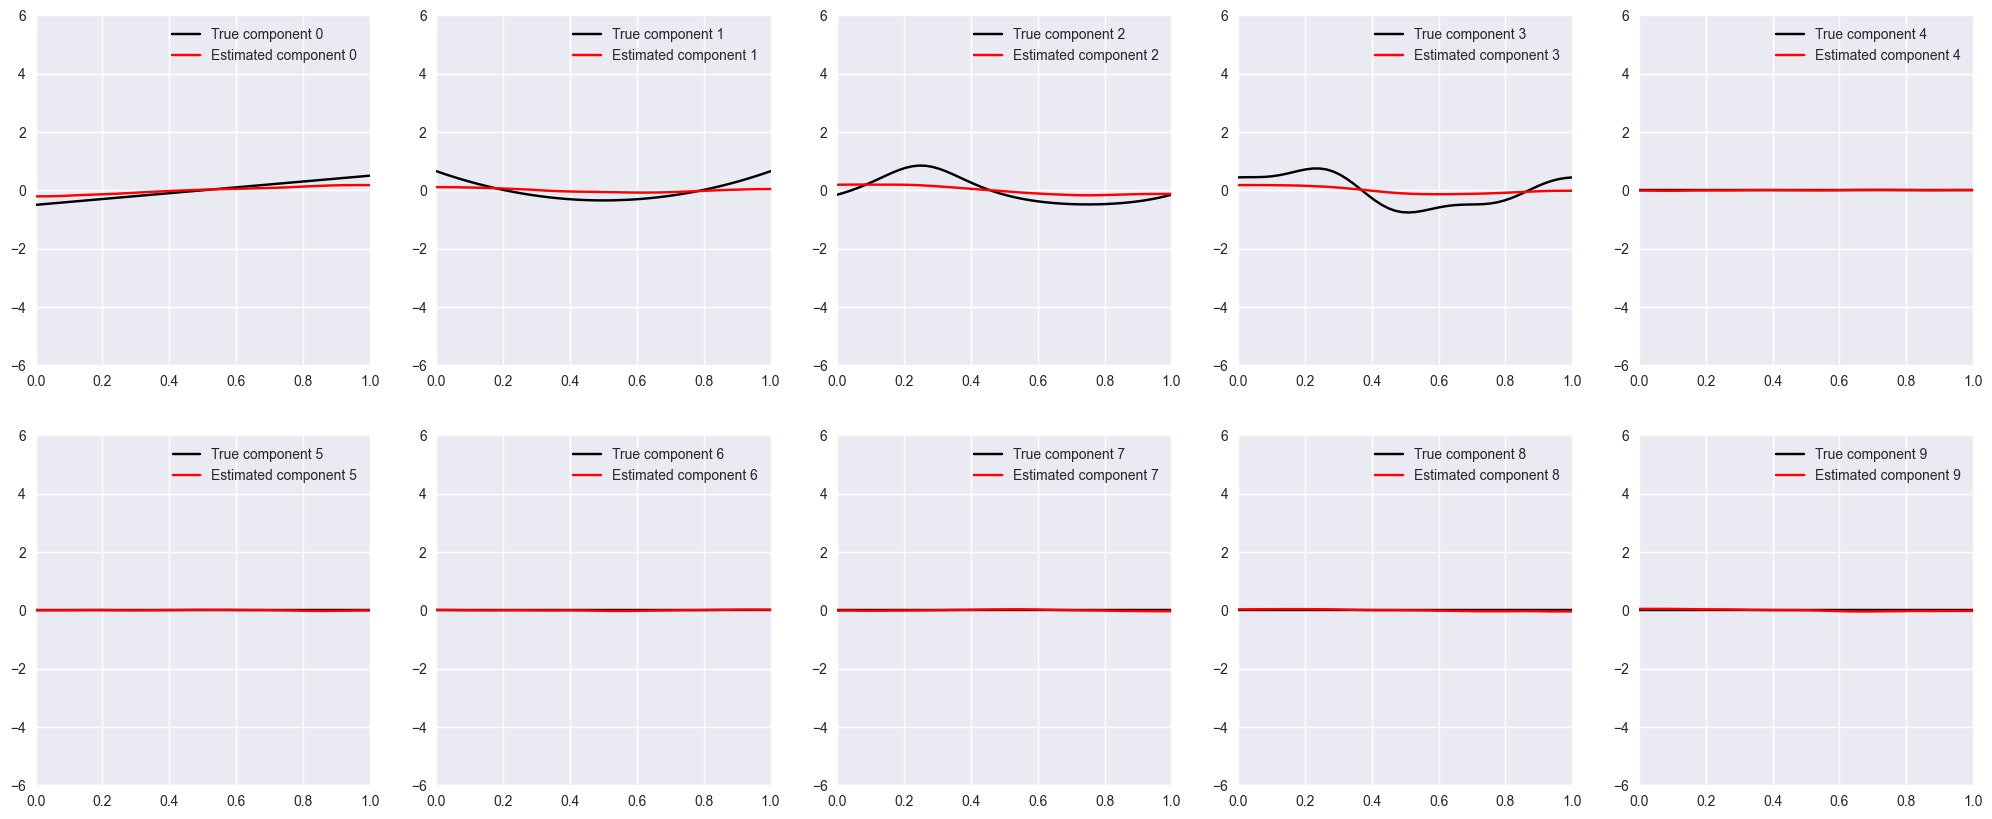

In [10]:
figure, axis = plt.subplots(2, math.ceil(D / 2), figsize=(25, 10))
for k, ax in zip(range(D), axis.ravel()):
    try:
        name = 'test_f' + str(k)
        ax.plot(test_x[:, k].numpy(), eval(name).numpy() - eval(name).numpy().mean(), 'k')
    except:
        print('Function component ' + str(k) + ' does not exist in the model')
        ax.plot(test_x[:, k].numpy(), torch.zeros_like(test_x[:, k]).numpy(), 'k')
    out_mean = comp_test_main_effect_ss[str(k)]
    ax.plot(test_x[:, k].numpy(), out_mean.detach().numpy(), 'r')
    ax.legend(['True component ' + str(k), 'Estimated component ' + str(k)])
    ax.set_xlim([0, 1])
    ax.set_ylim([-6, 6])


# (A)COSSO


When the dimension increases, the number of components to be estimated increases. Actually, only few of components are non-zeros. Then, the problem turns to a functional selection problem where the objective is to identify the non-informative components to put them to zeros and then estimate the informative components. The COmponent Selection and Smoothing Operator (COSSO module) allows this task that is do a sparse estimation of the functional components. It solves the following problem :
$$f \in argmin \sum_{i=1}^N (y_i−f(x_i ))^2+\lambda^{−1} \sum_{𝑗=1}^𝐽 𝑤_𝑗^{-1} \Vert 𝑃^𝑗 𝑓\Vert$$

We see that it is very related to Lasso estimation.
Similarly to SS, we have two tuning parameters : 
- the regularization parameter $\lambda$ tuned with cross validation 
- a weighting parameter $𝑤_𝑗$ set from an initial estimator : bigger $𝑤_𝑗$ means promotes zero $f_j$
When weights are different from 1, it refers to Adaptive COSSO ((A)COSSO) model. 

From [Lin, 2003], an equivalent expression iterates between an SS problem and a nonnegative garrote (optimization with $\ell_1$ norm over selection parameters as follows : 

- Solve the ss anova with some optimal value $\alpha$
- For the obtained functional components, solve the selection parameters with the nonnegative garrote with parameter M
- With the new selection parameters, solve the ss anova (weighted ss anova where weights are equal to selection parameters)


## Define the COSSO estimator

In [11]:
# Optionally, we define the weight of size equal to the numbers of function components. Default weights is 1. 

# It is possible to choose custom weights
# Ensure that the sum~1 (so that to not change the alpha range)
# This is an example of weight (not optimal), decomment this part to test

weight_main_effect = torch.tensor([0.001, 0.001, 0.001, 0.001, 1.66,  1.66, 1.66, 1.66, 1.66, 1.66])
weight_interaction_effect = None

# We can actually set the weights from SS estimator which is known as the "ACOSSO model" 
p = 2 # p norm of component 

weight_main_effect = torch.tensor([i.pow(p).mean() for i in comp_test_main_effect_ss.values()])
weight_main_effect = weight_main_effect/weight_main_effect.sum()*D
if model_order == 2:
    weight_interaction_effect = torch.tensor([i.pow(p).mean() for i in comp_test_interaction_effect_ss.values()])
    weight_interaction_effect = weight_interaction_effect/weight_interaction_effect.sum()*D*(D-1)/2



# Weight can be either None or a tuple of size model_order
if model_order == 1: 
    weight_cosso=(weight_main_effect,)
elif model_order == 2:
    weight_cosso=(weight_main_effect, weight_interaction_effect)

# Default weight is None 
#weight_cosso = None # Comment this line to use the adaptive weights (ACOSSO version)


# Finally, create the ss estimator
cosso_estimator = cosso.COSSO(ndims=D, weight=weight_cosso, model_order=model_order, poly_order=poly_order)

## Training

- Train the COSSO model for a given regularization parameter

In [12]:
M = 0.00001
_ = cosso_estimator.train(train_x, train_y, GCV=False, alpha=alpha_star, M=M, 
                                    solver='lasso', tol=1e-4, max_iter=100)

 - Get the optimal value of the regularization parameter with k-folds while training the model


 *Remark* : 
 - The cosso results are very dependend of the parameter M. 
 - Moreover, the optimal value of M is not very stabe. It depends on the random_state we use for shuffling data and train-test split in cross validation. 
 - The best set is found with trial-and-error for this example. This is a high limitation for real data

In [21]:
L = 200

if model_order==1:
    tab_M = 10. ** (torch.linspace(1, 2, L)) / N
elif model_order==2:
    # This may take some time
    tab_M = 10. ** (torch.linspace(-1, 0, L)) / N

M_star, loss_star = cosso_estimator.train(train_x, train_y, GCV=False, alpha=alpha_star, M=tab_M, folds=4,
                                        solver='lasso', tol=1e-3, max_iter=100, random_state=123456)




In [111]:
print('Optimal value for M is %0.6f' %(M_star.item()))

Optimal value for M is 0.000400


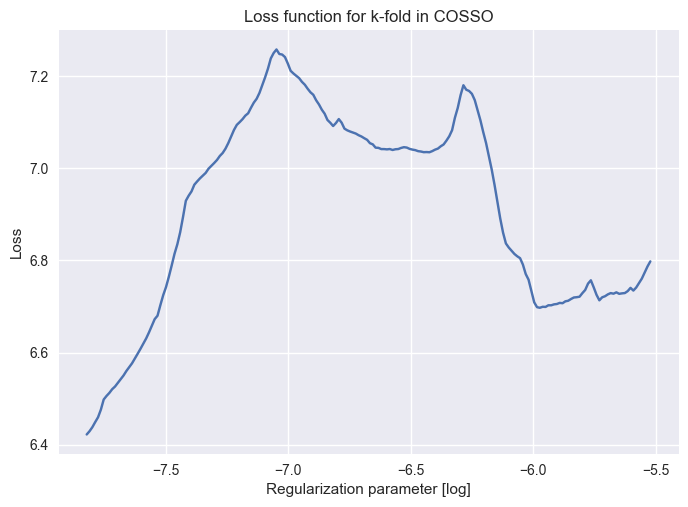

In [112]:
plt.plot(torch.log(tab_M), loss_star.detach()); 
plt.title('Loss function for k-fold in COSSO')
plt.xlabel('Regularization parameter [log]')
plt.ylabel('Loss')
plt.show()

- The selection power

The selection power is given by the outputscale

In [14]:
'selection_parameter' in [i for i in dir(cosso_estimator)]

True

In [31]:
if model_order == 1:
    main_selection = cosso_estimator.selection_parameter[0]
elif model_order == 2:
    main_selection, interaction_selection = cosso_estimator.selection_parameter

AttributeError: 'COSSO' object has no attribute 'selection_parameter'

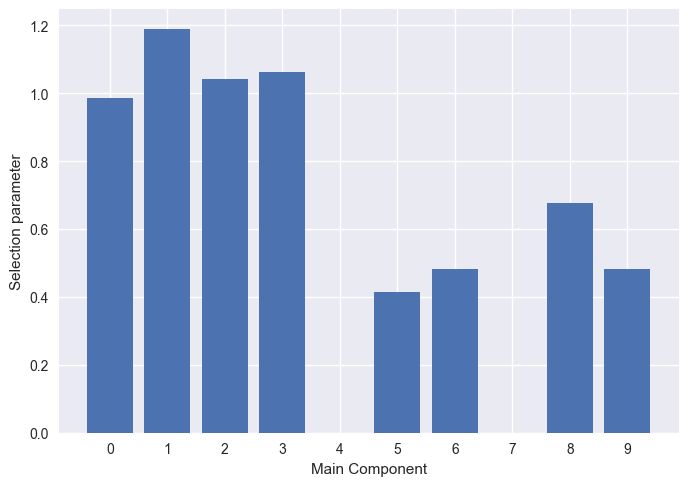

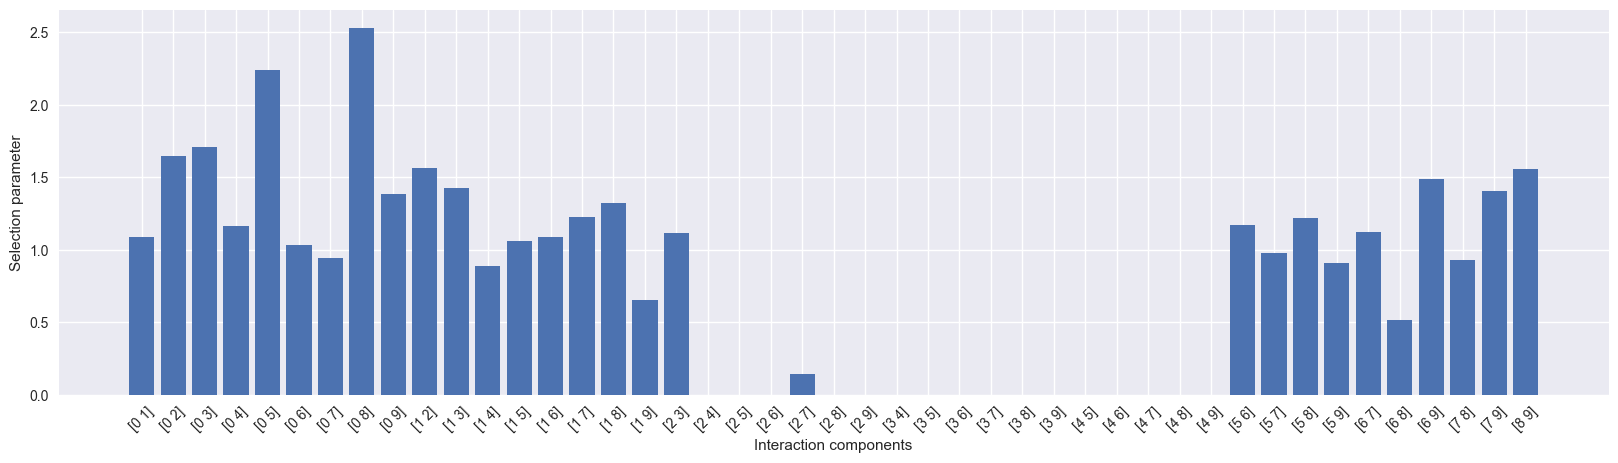

In [114]:
plt.figure()
x_bar = [str(i) for i in range(D)]
plt.bar(x_bar,main_selection )
plt.xlabel('Main Component')
plt.ylabel('Selection parameter')
plt.show()

if model_order == 2:
    plt.figure(figsize=(20, 5))
    index = torch.tensor([[i, j] for i in np.arange(0, D - 1)
                        for j in np.arange(i + 1, D)], dtype=torch.long)
    k = [[0, 1], [0, 2], [2, 3]]
    active_components = [first_order_InteractionEffect_to_index(D, list(j)) for j in k]
    inter_labels = [str(i) for i in list(index.numpy())]
    x_bar = [str(i.numpy()) for i in index]
    plt.bar(range(D*(D-1)//2), interaction_selection, tick_label=inter_labels)
    plt.xticks(fontsize=10, rotation=45)
    plt.xlabel('Interaction components')
    plt.ylabel('Selection parameter')
    #plt.grid()
    plt.show()

## Prediction

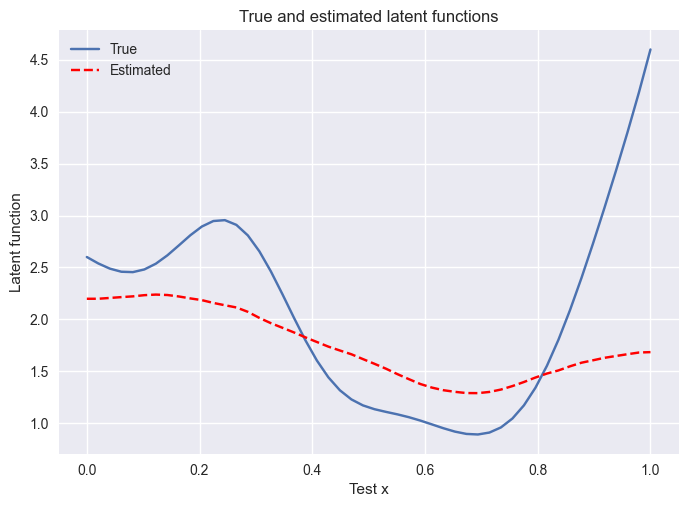

In [28]:
# Get the estimated latent
y_test_pred = cosso_estimator.predict(test_x)

plt.plot(test_x[:, 0], test_f, label='True')
plt.plot(test_x[:, 0], y_test_pred.detach(), '--r', label='Estimated')
plt.legend()
plt.xlabel('Test x')
plt.ylabel('Latent function');
plt.title('True and estimated latent functions');

In [29]:
# Get the estimated functional components

# Two methods : 

# First method : return a tuple (main_comp, inter_comp) where main_comp and inter_comp are tensors
comp_test_cosso =cosso_estimator.get_components(test_x)

if model_order == 1:
    comp_test_main_effect_cosso = comp_test_cosso
    # No interaction effect
elif model_order == 2:
    comp_test_main_effect_cosso = comp_test_cosso[0]
    comp_test_interaction_effect_cosso = comp_test_cosso[1]
    
# Second method : call predict and specifying kind argument => return a dictionary {index : component}
target_component = None # If target component is the 4 then set 4, for two 4 and 5 target components then set [4, 5]
comp_test_main_effect_cosso = cosso_estimator.predict(test_x, kind='main', component_index=target_component)
if model_order == 2:
    target_component = None # If target component is the (0,1) then set [0, 1] if (0,1) and (4,5) then set [[0, 1], [4, 5]]
    comp_test_interaction_effect_cosso = cosso_estimator.predict(test_x, kind='interaction', component_index=target_component)



Function component 4 does not exist in the model
Function component 5 does not exist in the model
Function component 6 does not exist in the model
Function component 7 does not exist in the model
Function component 8 does not exist in the model
Function component 9 does not exist in the model


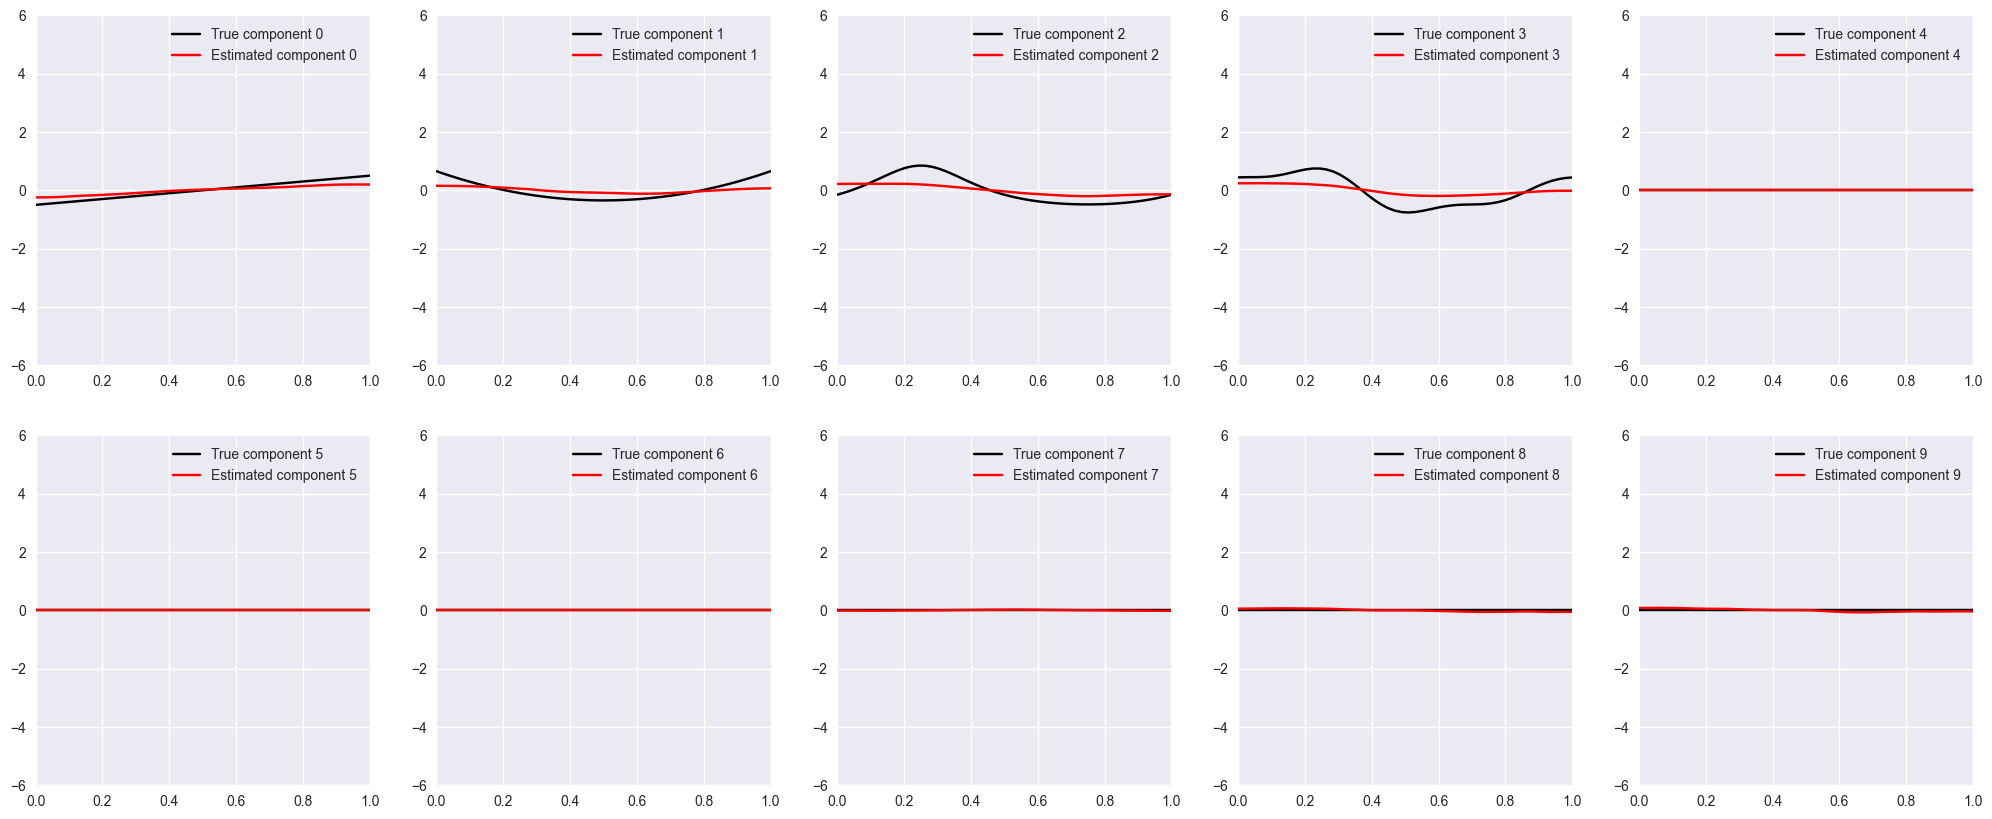

In [30]:
figure, axis = plt.subplots(2, math.ceil(D / 2), figsize=(25, 10))
for k, ax in zip(range(D), axis.ravel()):
    try:
        name = 'test_f' + str(k)
        ax.plot(test_x[:, k].numpy(), eval(name).numpy() - eval(name).numpy().mean(), 'k')
    except:
        print('Function component ' + str(k) + ' does not exist in the model')
        ax.plot(test_x[:, k].numpy(), torch.zeros_like(test_x[:, k]).numpy(), 'k')
    
    out_mean = comp_test_main_effect_cosso[str(k)]
    ax.plot(test_x[:, k].numpy(), out_mean.detach().numpy(), 'r')
    ax.legend(['True component ' + str(k), 'Estimated component ' + str(k)])
    ax.set_xlim([0, 1])
    ax.set_ylim([-6, 6])


# Local Global Bayesian Component Selection (LGBayesCOS)

Using (A)COSSO models, we are able to select only informative components while setting non-informative ones to zero. However, we loose the link with Gaussian process. Then, we loose probability interpretation and uncertainty quantification. 
In this package, we provide Bayesian component selection using the lgbayescos module. 
We provide HMC (and NUTS) and Stein methods to do sampling. 
The Bayesian model is based on global-local shrinking hierarchical models.

Given a model order $r$, we assume $Q_k$ functional components in each kind of effects $k$. We have the following model: 

- Global parameters : $$\forall k \in \{1, \ldots, r \} \quad  \lambda_k \sim 𝑝(\lambda_k)$$
- Local parameters :  $$\forall k \in \{1, \ldots, r \} \forall j \in \{1, \ldots, Q_k \} \quad  \gamma_j \sim 𝑝(\gamma_j)$$
- Function component : $$\forall k \in \{1, \ldots, r \} \forall j \in \{1, \ldots, Q_k \} \quad f_j \sim \mathcal{GP}(0, \lambda_k \gamma_j k_j)$$
- Constant function : $$c \sim p(c)$$
- Noise : $$\sigma^2 \sim p(\sigma^2)$$
- Observation : $$y_i \sim \mathcal{N} \left( c+\sum_{k=1}^r\sum_{j=1}^{Q_k} f_j(x_i), \sigma^2\right)$$


To define a Bayesian selection model, we need to define 3 requirements:
- The GP Sobolev model using kernels similarly to ss and (A)cosso that enherits from models.model
- The priors and the constraints for the GP model parameters
- The sampler algorithm

Then, construct and run the resulting the LGBayesCOS model

## First, define the GP model

In [25]:
gpmodel = model.SobolevGPModel(train_x, train_y, poly_order=poly_order, 
                                model_order=model_order, residual=residual, coef=coef)
# gpmodel.enable_latent() # Decomment if you want to estimate the latent in the sampling : 
#                           i.e use joint likelihood instead of marginalized likelihood.
#                           This is mandatory for gaussian likelihood but for non-gaussian likelihoods,
#                           latent is automaticlaly enabled. To change the likelihood, 
#                           set SobolevGPModel(..., likelihood=lik) where lik is from gpytorch.likelihoods.
#                           Warning : Sampling is possible but prediction with non-Gaussian models is not implemented yet 

In [26]:
# It also possible to use the sparse version of the GP model with inducing points 
sparse = False # Set to True to use sparse model
if sparse:
    inducing_points = torch.nn.Parameter(torch.rand(20, 10))
    num_inducing_points = inducing_points.shape[0]
    gpmodel = model.SparseSobolevGPModel(train_x, train_y, poly_order=poly_order, 
                                    model_order=model_order, residual=residual, coef=coef,
                                    inducing_points=inducing_points)

## Second, define the priors and the constraints

- Constraints are defined from gpytorch.constraints such as Interval, GreaterThan, Positive, LessThan 

- Please see https://docs.gpytorch.ai/en/stable/constraints.html 

- Priors are defined from bayesanova.models.prior

- Priors and constraints are defined in tuple format (main_effect, interaction_effect)

In [27]:
# Initialize the constraints and priors as dict
constraints_dict = dict()
priors_dict = dict()

- Global parameters

In [28]:
global_scale_constraint = (gpytorch.constraints.Positive(),) if model_order == 1 else (
    gpytorch.constraints.Positive(), gpytorch.constraints.Positive())

    
global_scale_prior = (prior.HoreshoeMixingPrior(scale=torch.tensor(100.0)),) if model_order == 1 else (
    prior.HalfCauchyPrior(scale=torch.tensor(50.0)), prior.HalfCauchyPrior(scale=torch.tensor(50.0)))

if residual:
    global_scale_constraint = global_scale_constraint + (gpytorch.constraints.Positive(),)
    global_scale_prior = global_scale_prior + (prior.HoreshoeMixingPrior(scale=torch.tensor(200.0)),)

# Add to dict
constraints_dict['global'] = global_scale_constraint
priors_dict['global'] = global_scale_prior


- Local parameters

In [29]:
# These parameters are the scales of the priors
# Please refer to the definition of the priors for more information
# Example : for Dirichlet, this the mean pourcentage of active components 0.5=> 50%
# For others priors : defaults values are equal to 1
main_effect_adaptive_scale = 0.5 * torch.ones(D)
interaction_effect_adaptive_scale = 0.5 * torch.ones(D * (D - 1) // 2)

# It is also possible, similarly to the weights for ACOSSO, to get adaptive scales from previous estimators
adaptive = True # Set to True to use adaptive scales
p = 2 
if adaptive:
   main_effect_adaptive_scale = torch.tensor([i.pow(p).mean() for i in comp_test_main_effect_ss.values()])
   main_effect_adaptive_scale = main_effect_adaptive_scale/main_effect_adaptive_scale.sum()*D
   if model_order == 2:
      interaction_effect_adaptive_scale = torch.tensor([i.pow(p).mean() for i in comp_test_interaction_effect_ss.values()])
      interaction_effect_adaptive_scale = interaction_effect_adaptive_scale/weight_interaction_effect.sum()*D*(D-1)/2

# For Dirichlet prior, if we want an isotropic scales i.e the same scale for all the componenets
# (less informative prior about which component is active but just information about the number of active components),
# we can estimate the scale by estimating the number of active components from previous estimation
isotropic_info = False # set to True to use isotropic scales estimated from previous estimations, only valid for Dirichlet
def get_number_active_componenets(val, threshold=0.9):
   sorted_val, _ = torch.sort(val/val.sum(), descending=True)
   mask = torch.cumsum(sorted_val, dim=0)<threshold
   num_active = mask[mask==True].size()[0] + 1
   return num_active/val.size()[0]*torch.ones_like(val)

if isotropic_info:
   main_effect_adaptive_scale = get_number_active_componenets(torch.tensor([i.pow(p).mean()
                                                            for i in comp_test_main_effect_ss.values()]))
   
   if model_order == 2:
      interaction_effect_adaptive_scale = torch.tensor([i.pow(p).mean() for i in comp_test_interaction_effect_ss.values()])
      interaction_effect_adaptive_scale = get_number_active_componenets(interaction_effect_adaptive_scale)

In [30]:
#main_effect_SparsePrior = prior.DirichletMixingPrior(scale=main_effect_adaptive_scale)
#main_effect_SparsePrior = prior.HoreshoeMixingPrior(scale=main_effect_adaptive_scale)
main_effect_SparsePrior = prior.LaplaceMixingPrior(scale=main_effect_adaptive_scale)
#main_effect_SparsePrior = prior.StudentMixingPrior(scale=main_effect_adaptive_scale, freedom=0.2)

#interaction_effect_SparsePrior = prior.DirichletMixingPrior(scale=interaction_effect_adaptive_scale)
#interaction_effect_SparsePrior = prior.HoreshoeMixingPrior(scale=interaction_effect_adaptive_scale)
interaction_effect_SparsePrior = prior.LaplaceMixingPrior(scale=interaction_effect_adaptive_scale)
#interaction_effect_SparsePrior = prior.StudentMixingPrior(scale=interaction_effect_adaptive_scale)


local_scale_prior = (main_effect_SparsePrior,) if model_order == 1 else (
    main_effect_SparsePrior, interaction_effect_SparsePrior)

# For Dirichlet mixing prior, the outputscales should be in the simplex (sum=1). 
# We can add explicicity this constraint here with prior.SimplexConstraint (To Do)
# If not mentionned, this constraint will be handled in the prior automatically
# Such normalization can be done for any other prior (To DO)
local_scale_constraint = (gpytorch.constraints.Positive(),) if model_order == 1 else (
    gpytorch.constraints.Positive(), gpytorch.constraints.Positive())


# Add to dict
constraints_dict['local'] = local_scale_constraint
priors_dict['local'] = local_scale_prior

- Mean and noise

In [31]:
mean_prior = gpytorch.priors.NormalPrior(0, 10)
mean_constraint = None # No constraint in mean component

# Add to dict
constraints_dict['mean'] = mean_constraint
priors_dict['mean'] = mean_prior


noise_constraint = gpytorch.constraints.Positive()
noise_prior = prior.HalfCauchyPrior(10)

# Add to dict
constraints_dict['noise'] = noise_constraint
priors_dict['noise'] = noise_prior

In [32]:
constraints_dict

{'global': (Positive(),),
 'local': (Positive(),),
 'mean': None,
 'noise': Positive()}

In [33]:
priors_dict

{'global': (HoreshoeMixingPrior(),),
 'local': (LaplaceMixingPrior(rate: torch.Size([10])),),
 'mean': NormalPrior(),
 'noise': HalfCauchyPrior()}

- *Optional* : there are several ways to initialize the sampling algorithm.

In this package, we can initilaize with :
- Samples from prior (init_strategy='prior')
- Samples with uniform samples (init_strategy='unif') 
- Given values (init_stratgey={key:value} with key in ["noise", "mean", "global main", "local main",
                                "global interaction", "local interaction"])

The two latter init strategies are for the moment available only for MCMC. 

In [34]:
init_strategy = 'prior'

use_init_values = False # Set to True to set init values, only available for MCMC
if use_init_values is True:
    init_noise = torch.tensor([10.0])
    init_mean = torch.tensor([0.0])
    init_local_main = torch.ones((D, ))/D
    init_global_main = torch.tensor([100.0])
    init_local_interaction = torch.ones((D*(D-1)//2, ))/D/(D-1)*2
    init_global_interaction = torch.tensor([100.0])
    if model_order == 1:
        init_strategy = {'noise':init_noise, 'local main':init_local_main, 'global main':init_global_main, 'mean':init_mean}
    elif model_order == 2: 
        init_strategy = {'noise':init_noise, 'local main':init_local_main, 'global main':init_global_main, 'mean':init_mean, 
                        'local interaction':init_local_interaction, 'global interaction':init_global_interaction}

## Third, choose the sampling algorithm

The Bayesian component selection offers the possibility to solve the problem using optimization (MAP) or sampling.

For now, there exists 4 sampling methods:

- Hamiltonian Monte Carlo which is MCMC algorithm => samplers.mcmc.HMC
- NUTS which is a variant for HMC => samplers.mcmc.hmc
- Stein Varitional Gradient Descent (SVGD) which is a particle methods => samplers.gpstein.SVGD
- Slice Stein Variational Gradient Descent (SSVGD) which is a variant of SVGD => samplers.gpstein.SSVGD

The latter algorithm needs to install the package Sliced_Kernelized_Stein_Discrepancy from https://github.com/WenboGong/Sliced_Kernelized_Stein_Discrepancy

### - MCMC example : either HMC or NUTS

Please refer to to samplers.mcmc module for more information about arguments

In [35]:
mcmc_estimator = lgbayescos.LGBayesCOS(model=gpmodel, 
                                        constraints_dict=constraints_dict,
                                        priors_dict=priors_dict, 
                                        sampler='HMC', 
                                        # Now define the kwargs of the sampler
                                        num_samples = 4000,
                                        warmup_steps = 6000,
                                        step_size=1e-4,
                                        num_steps=5,
                                        adapt_step_size=True,
                                        adapt_mass_matrix=False,
                                        full_mass=False,
                                        target_accept_prob=0.7,
                                        num_chains=1,
                                        init_strategy=init_strategy) 

### - Stein example : either GPSVGD or GPSliceSVGD

Please refer to samplers.stein for more information 

**Remark** : Stein methods do not seem adapted for our sampling problem when the priors are not very informative. We should use good priors that generate values not far from the target (for example by using the adaptive version for the prior scales). Otherwise, Stein algorithm fails to explore the target state space : some of particles do not converge. 





In [36]:
kernel =  SteinRBFkernel()
kernel = SteinIMQkernel()
optimizer = RMSprop 
optimizer_params = {'lr':0.05, 'momentum':0.9}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'factor':0.5, 'patience':50, 'verbose':False, 'threshold':0.00001, 'min_lr':1e-5}
#scheduler = None

stein_estimator = lgbayescos.LGBayesCOS(model=gpmodel, 
                                        constraints_dict=constraints_dict,
                                        priors_dict=priors_dict, 
                                        sampler='SVGD', 
                                        # Now define the kwargs of the sampler
                                        kernel=kernel,
                                        optimizer=optimizer,
                                        optimizer_params=optimizer_params, 
                                        scheduler=scheduler,
                                        scheduler_params=scheduler_params,
                                        num_particles = 100,
                                        warmup_steps = 1000,
                                        num_chains=1,
                                        r_coef=1.0,
                                        mode='multi',
                                        stochastic=True,
                                        init_strategy='prior')


## Train

In [37]:
bayes_estimator = mcmc_estimator

- Run the sampling algorithm 

In [38]:
bayes_estimator.train(train_x, train_y)

Sample: 100%|██████████| 10000/10000 [00:56, 177.55it/s, step size=1.01e-01, acc. prob=0.714]


- Get training summary 

In [39]:
bayes_estimator.train_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          noise variance[0]      5.11      1.03      5.07      3.44      6.69    109.42      1.05
           constant mean[0]      5.19      0.27      5.18      4.74      5.61    104.88      1.03
main effect global scale[0]      6.75      2.48      6.42      2.93     10.40     43.99      1.02
 main effect local scale[0]      2.36      1.48      2.04      0.35      4.44     31.33      1.05
 main effect local scale[1]      1.07      0.57      0.97      0.25      1.82     37.89      1.09
 main effect local scale[2]      2.47      1.32      2.18      0.63      4.25     20.19      1.18
 main effect local scale[3]      5.71      2.73      5.14      1.75      9.40     50.49      1.00
 main effect local scale[4]      0.04      0.05      0.02      0.00      0.11      7.57      1.32
 main effect local scale[5]      0.25      0.23      0.19      0.01      0.58      6.86      1.18
 main effect local 

- Get the samples 

In [40]:
samples = bayes_estimator.get_named_samples()

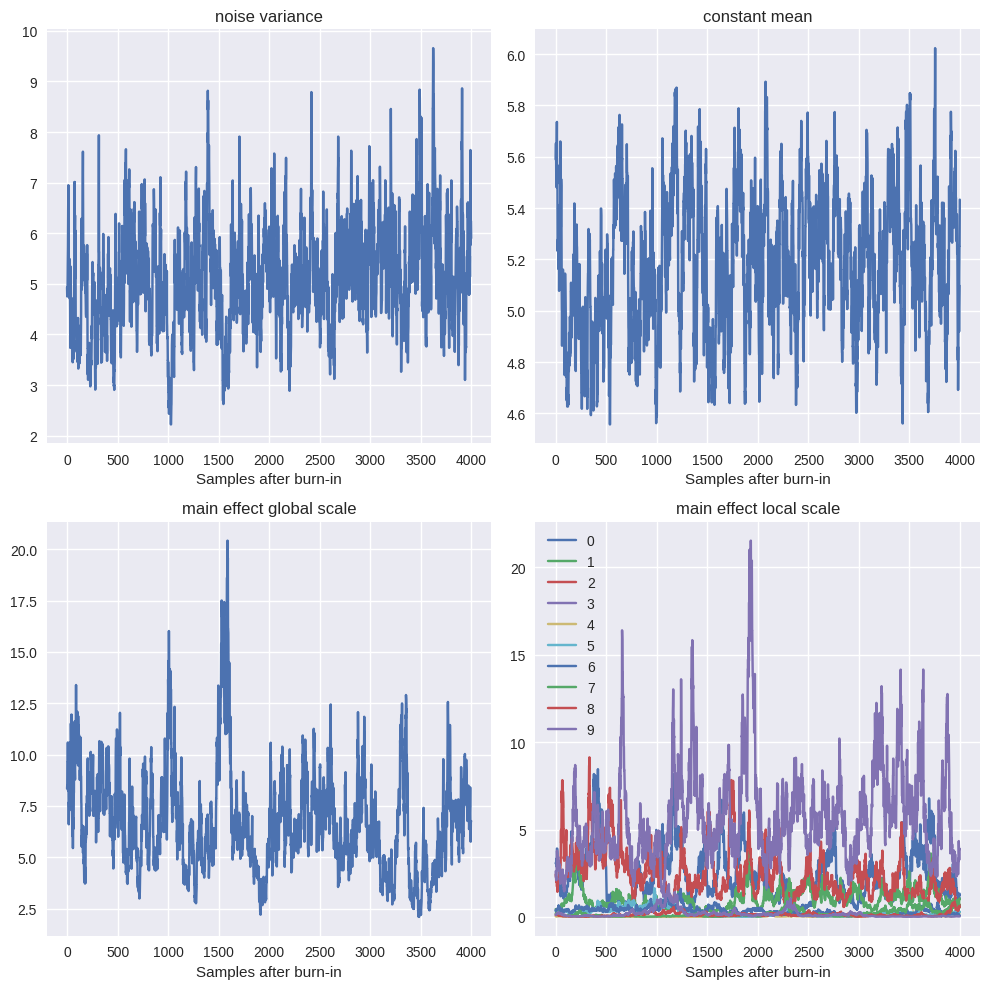

In [57]:
# Plot samples (only for noise, mean and main components)
figure, axis = plt.subplots(2, 2, figsize=(10, 10))
for name, s, ax in zip(samples.keys(), samples.values(), axis.ravel()):
    #print(name)
    for i in range(0, s.shape[1]):
        ax.plot(s[:, i], label=str(i))
    ax.set_title(name)
    if (s.shape[1] > 1) and (s.shape[-1]<=10):
        ax.legend()
    ax.set_xlabel('Samples after burn-in')


plt.tight_layout()
plt.show()

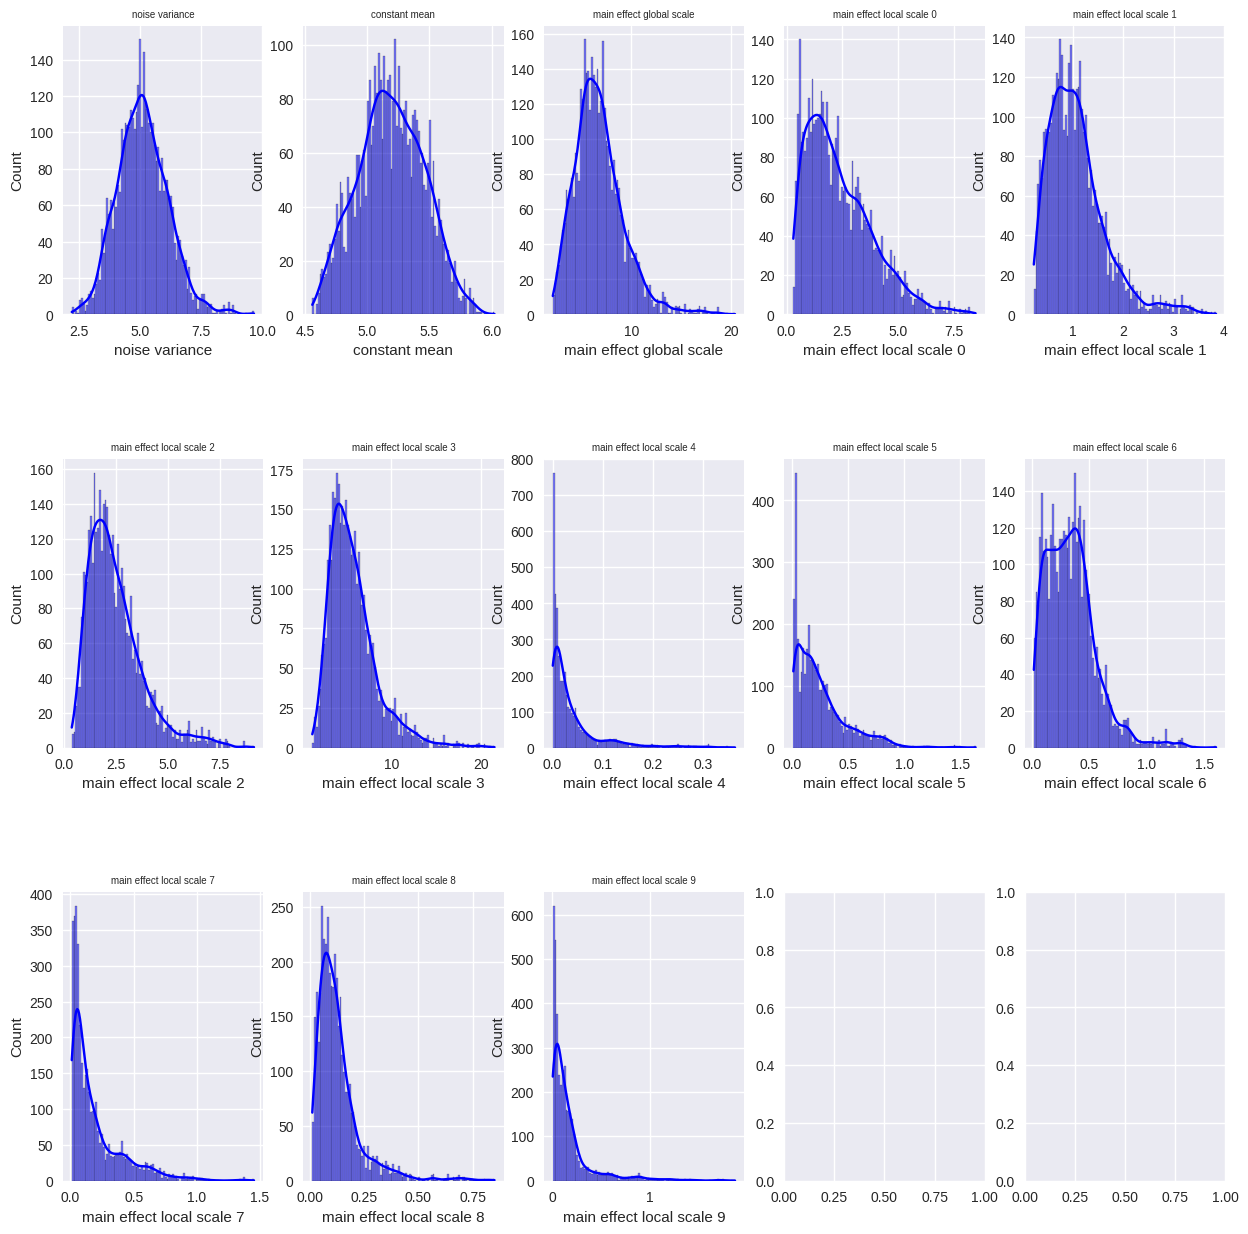

In [42]:
# Show marginal densities 
draw_parameters_densities(samples, num_col=5)

- Evaluate selection power 

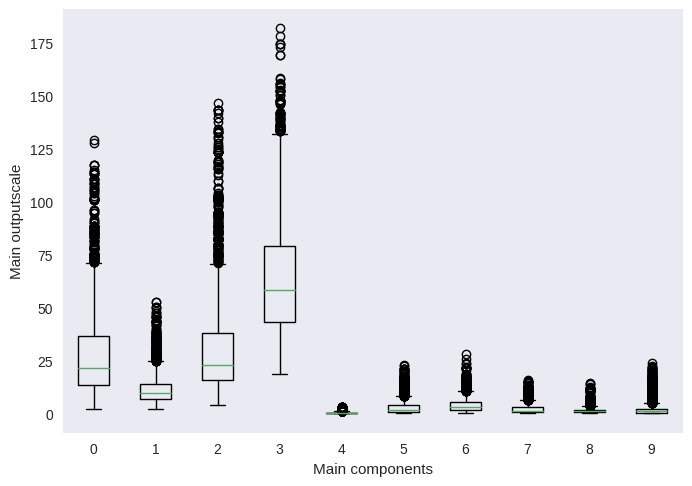

In [43]:
main_selection, interaction_selection = bayes_estimator.selection_parameter

# Display selection parameters
main_labels = [str(i) for i in range(D)]
plt.figure()
plt.boxplot(main_selection.detach().numpy(), labels=main_labels)
plt.grid()
plt.ylabel('Main outputscale');
plt.xlabel('Main components');

if model_order == 2:
    plt.figure(figsize=(20, 5))
    index = torch.tensor([[i, j] for i in np.arange(0, D - 1)
                        for j in np.arange(i + 1, D)], dtype=torch.long)
    k = [[0, 1], [0, 2], [2, 3]]
    active_components = [first_order_InteractionEffect_to_index(D, list(j)) for j in k]
    inter_labels = [str(i) for i in list(index.numpy())]
    x_bar = [str(i.numpy()) for i in index]
    plt.boxplot(interaction_selection.detach().numpy(), labels=inter_labels)
    plt.xticks(fontsize=10, rotation=45)
    plt.grid()
    plt.ylabel('Interaction outputscale');
    plt.xlabel('Interaction components');


## Prediction

- In order to run fast prediction, please first run predict_on method.

- This method computes and saves useful informations in caches to allows fast predictions for subsequent calls of predict method

In [44]:
num_samples_inference=20 # Number of samples used for inference
bayes_estimator.predict_on(num_samples=num_samples_inference)

- Now, we can do predictions using predict method
- Predictions can be done for one or more main component (kind='main'), interaction component (kind='interaction') or latent (kind='latent') or outcome (kind='outcome')
- The method predict() returns a dictionnary containing predicted components 
- To accelerate computations, we can also use gpytorch.settings for fast computation

For more information, see https://docs.gpytorch.ai/en/stable/settings.html 

### Predicted components

In [45]:
# Provide target_component 
# If None then return all components of the same kind

# For main component, provide the index. For interaction, provide the couple [i, j] defining the interaction such that i<j

target_main_component = 0 # e.g to get the first 3 main components set [0, 1, 2]
target_interaction_component = [0, 1] # e.g to get the first 3 ineteraction components set [[0,1], [0,2], [0, 3]]

with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(30):
    predicted_main_component = bayes_estimator.predict(test_x, kind='main', 
                                                    component_index=target_main_component)
    
    if model_order == 2:
        predicted_interaction_component = bayes_estimator.predict(test_x, kind='interaction', 
                                                                component_index=target_interaction_component)
    else: 
        predicted_interaction_component = None



In [46]:
print('Main :',predicted_main_component)
print('Interaction :', predicted_interaction_component)


Main : {'0': MultivariateNormal(loc: torch.Size([20, 50]))}
Interaction : None


In [47]:
# Now compute all components
with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(30):
    predicted_main_component = bayes_estimator.predict(test_x, kind='main')

In [48]:
# Get mean, covariance and variances of main components
with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(30):
    mean_main_output_functions = {k: v.mean for (k, v) in predicted_main_component.items()}
    
    # Sometimes the approximation does not work: some issues with gyptorch.lazy_tensor
    try:
        variance_main_output_functions = {k: v.variance for (k, v) in predicted_main_component.items()}
    except: 
        print('Approximation not possible => explicit computation after delazifying')
        variance_main_output_functions = {k: torch.diagonal(v.covariance_matrix, dim1=-2, dim2=-1) for (k, v) in predicted_main_component.items()}


In [49]:
# This is how to get a sample from predictive density
with gpytorch.settings.fast_pred_samples():
    samples_main_output_functions = {k: v.rsample() for (k, v) in predicted_main_component.items()}

- First option : Display mean and confidence intervals of predictive densities

Function component 4 does not exist in the model
Function component 5 does not exist in the model
Function component 6 does not exist in the model
Function component 7 does not exist in the model
Function component 8 does not exist in the model
Function component 9 does not exist in the model


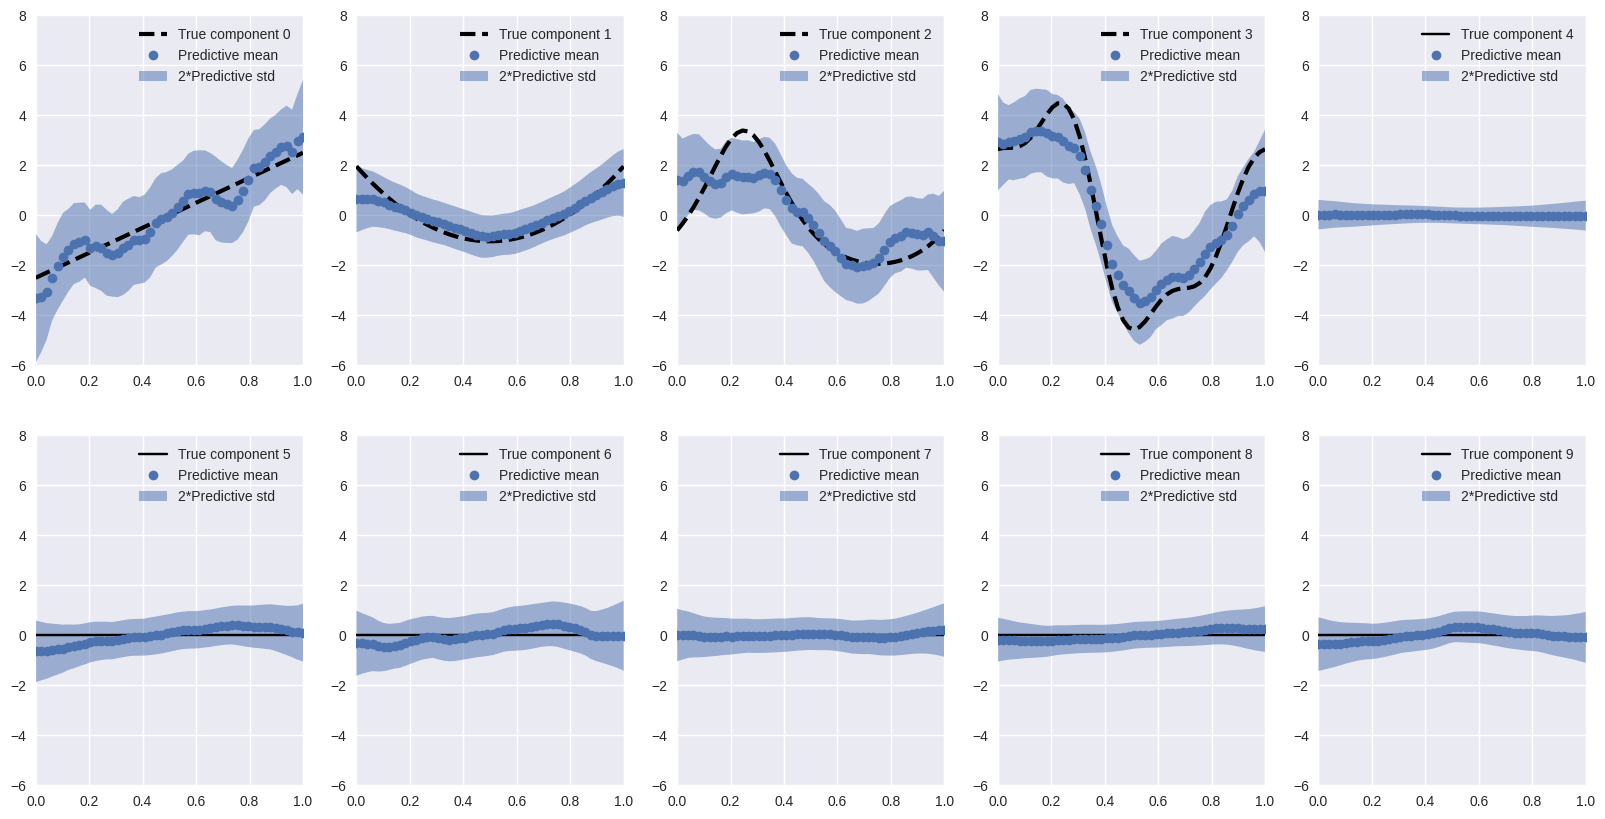

In [50]:
figure, axis = plt.subplots(2, math.ceil(D / 2), figsize=(20, 10))
for k, ax in zip(range(D), axis.ravel()):
    try:
        name = 'test_f' + str(k)
        ax.plot(test_x[:, k].numpy(), eval(name).numpy() - eval(name).numpy().mean(), '--k', linewidth=3)
    except:
        print('Function component ' + str(k) + ' does not exist in the model')
        ax.plot(test_x[:, k].numpy(), torch.zeros_like(test_x[:, k]).numpy(), 'k')
    global_mean = torch.mean(mean_main_output_functions[str(k)], dim=0, keepdim=True)
    out_variance = variance_main_output_functions[str(k)] + \
                   torch.abs(mean_main_output_functions[str(k)] - global_mean) ** 2

    mean = torch.mean(mean_main_output_functions[str(k)][:num_samples_inference, ...], dim=0)
    var = torch.mean(out_variance[:num_samples_inference], dim=0)
    # Plot predictive means as blue line
    ax.plot(test_x[:, k].numpy(), mean.detach().numpy(), 'o')
    lower = mean - 2 * torch.sqrt(var)
    upper = mean + 2 * torch.sqrt(var)
    ax.fill_between(test_x[:, k].numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)

    ax.legend(['True component ' + str(k), 'Predictive mean', '2*Predictive std'])
    ax.set_xlim([0, 1])
    ax.set_ylim([-6, 8])

- Second option : Display mean and confidence intervals of predictive densities from samples

Function component 4 does not exist in the model
Function component 5 does not exist in the model
Function component 6 does not exist in the model
Function component 7 does not exist in the model
Function component 8 does not exist in the model
Function component 9 does not exist in the model


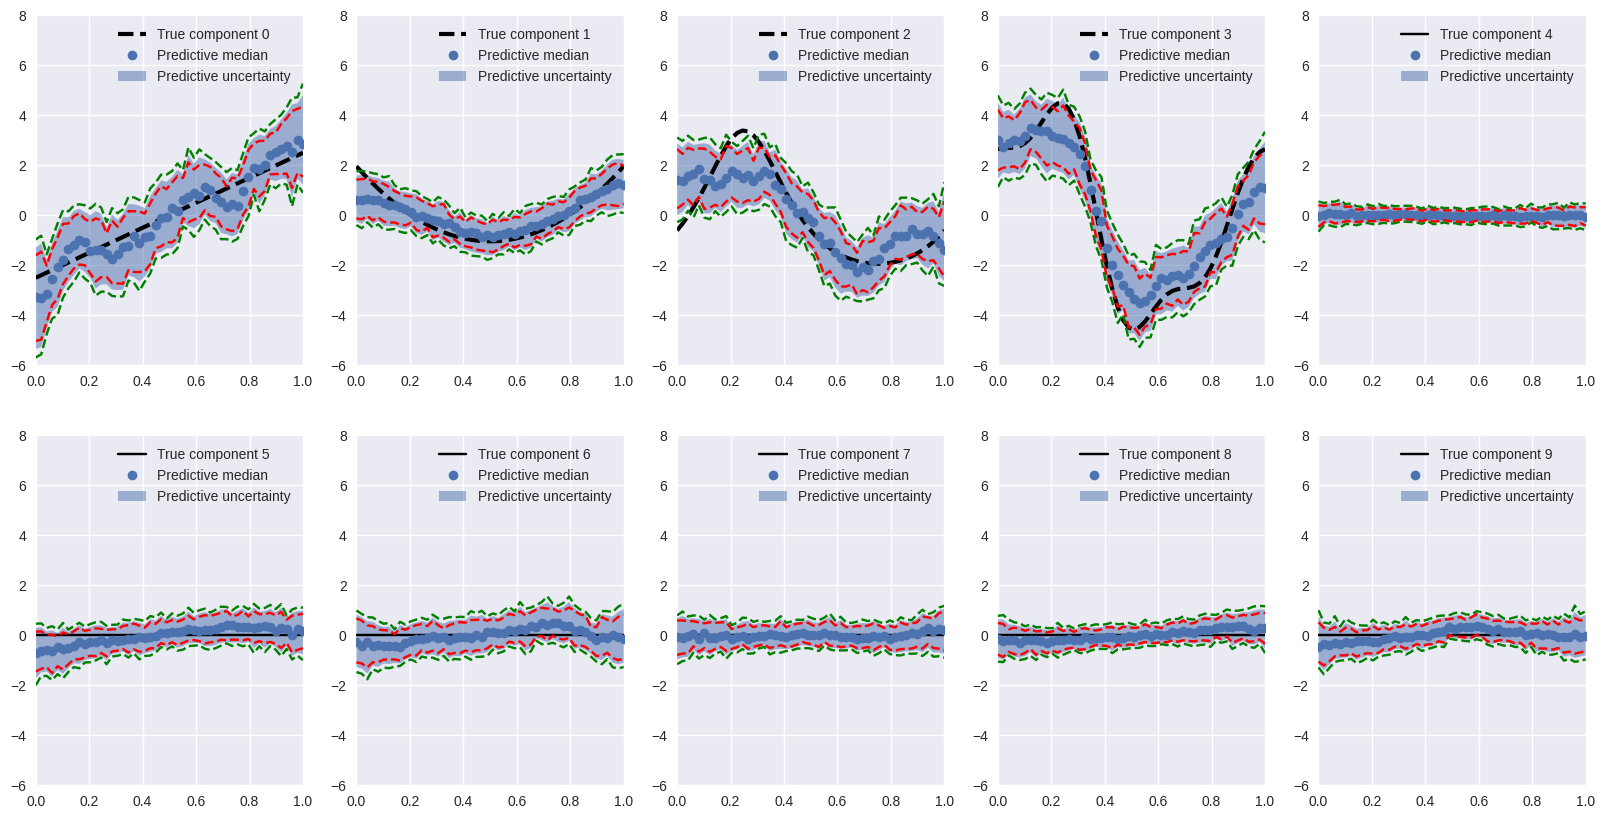

In [51]:
figure, axis = plt.subplots(2, math.ceil(D / 2), figsize=(20, 10))
for k, ax in zip(range(D), axis.ravel()):
    try:
        name = 'test_f' + str(k)
        ax.plot(test_x[:, k].numpy(), eval(name).numpy() - eval(name).numpy().mean(), '--k', linewidth=3)
    except:
        print('Function component ' + str(k) + ' does not exist in the model')
        ax.plot(test_x[:, k].numpy(), torch.zeros_like(test_x[:, k]).numpy(), 'k')
    out_mean = mean_main_output_functions[str(k)]
    out_variance = variance_main_output_functions[str(k)]
    mean = torch.mean(out_mean, dim=0)
    num_samples_to_estimate_CI = 100
    dist_mean = torch.zeros(num_samples_to_estimate_CI, test_x.shape[0])
    dist_var = torch.zeros(num_samples_to_estimate_CI, test_x.shape[0])
    for j in range(test_x.shape[0]):
        index = torch.multinomial(1 / num_samples_inference * torch.ones(num_samples_inference),
                                num_samples_to_estimate_CI, True)
        dist_mean[:, j] = out_mean[index, j]
        dist_var[:, j] = out_variance[index, j]

    dist = gpytorch.distributions.MultivariateNormal(dist_mean, gpytorch.lazy.DiagLazyTensor(dist_var))

    samples_k = dist.sample()
    n_k = samples_k.shape[0]
    upper = torch.quantile(samples_k, 0.95, dim=0)
    lower = torch.quantile(samples_k, 0.05, dim=0)
    median = torch.quantile(samples_k, 0.5, dim=0)
    vhq, vlq, Lq, Hq = variance_estimation_from_samples(samples_k)
    # Plot predictive means as blue line
    ax.plot(test_x[:, k].numpy(), median.numpy(), 'o')
    ax.fill_between(test_x[:, k].numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.legend(['True component ' + str(k), 'Predictive median', 'Predictive uncertainty'])
    ax.plot(test_x[:, k].numpy(), (upper - 2 * torch.sqrt(vhq / n_k)).detach().numpy(), '--r')
    ax.plot(test_x[:, k].numpy(), (upper + 2 * torch.sqrt(vhq / n_k)).detach().numpy(), '--g')
    ax.plot(test_x[:, k].numpy(), (lower - 2 * torch.sqrt(vlq / n_k)).detach().numpy(), '--g')
    ax.plot(test_x[:, k].numpy(), (lower + 2 * torch.sqrt(vlq / n_k)).detach().numpy(), '--r')

    ax.set_xlim([0, 1])
    ax.set_ylim([-6, 8])

- Predicted residual

In [52]:
with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(30):
    if residual:
        predicted_residual = bayes_estimator.predict(test_x, kind='residual')
    else:
        predicted_residual = None

print('Residual:', predicted_residual)

Residual: None


## Predicted outcome and latent

In [53]:
with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(30):
    predicted_latent = bayes_estimator.predict(test_x, kind='latent')
    predicted_outcome = bayes_estimator.predict(test_x, kind='outcome')


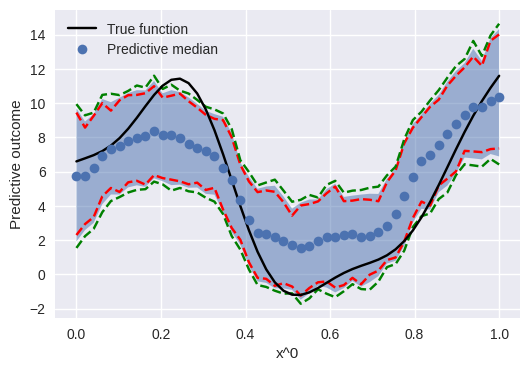

In [54]:
# Display predicted latent or predicted outcome

#f_preds = predicted_outcome
f_preds = predicted_latent


f, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(train_x[:, 0].numpy(), train_f.numpy(), '*k')
axis_x, index_sorted = test_x[:, 0].sort()
ax.plot(axis_x.numpy(), test_f[index_sorted].numpy(), '-k', zorder=10)
mean = torch.mean(f_preds.mean[:, index_sorted], dim=0)
samples_t = f_preds.sample(sample_shape=torch.Size([10]))
samples_t = torch.cat([s[:400] for s in samples_t], dim=0)
n_k = samples_t.shape[0]
upper = torch.quantile(samples_t, 0.95, dim=0)
lower = torch.quantile(samples_t, 0.05, dim=0)
median = torch.quantile(samples_t, 0.5, dim=0)
upper = upper[index_sorted]
lower = lower[index_sorted]
dist = gpytorch.distributions.MultivariateNormal(f_preds.mean, gpytorch.lazy.DiagLazyTensor(f_preds.variance))
samples_t = dist.sample()
vhq, vlq, Lq, Hq = variance_estimation_from_samples(samples_t)
vhq = vhq[index_sorted]
vlq = vlq[index_sorted]
ax.plot(axis_x.detach().numpy(), mean[index_sorted].detach().numpy(), 'o', zorder=10)
# Shade between the lower and upper confidence bounds
ax.fill_between(axis_x.numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
ax.set_xlabel('x^0')
ax.set_ylabel('Predictive outcome')
ax.legend(['True function', 'Predictive median'])
ax.plot(axis_x.detach().numpy(), (upper - 2 * torch.sqrt(vhq / n_k)).detach().numpy(), '--r')
ax.plot(axis_x.detach().numpy(), (upper + 2 * torch.sqrt(vhq / n_k)).detach().numpy(), '--g')
ax.plot(axis_x.detach().numpy(), (lower - 2 * torch.sqrt(vlq / n_k)).detach().numpy(), '--g')
ax.plot(axis_x.detach().numpy(), (lower + 2 * torch.sqrt(vlq / n_k)).detach().numpy(), '--r')
#ax.set_ylim([-4, 16]); 